## Overview

In this section we'll go over in brief how to interact with the firmware in order to command SMuRF and get information back from it. We'll cover 4 major topics:
0. Gets and puts
1. Commanding tones
2. Reading response
3. Firmware structure

### Gets and puts

SMuRF is commanded and read out via an EPICS server, which maps the physical registers of the electronics to the firmware. This is further wrapped in a layer called PyRogue, which maps the firmware registers to human-readable names. The registers are termed "process variables", or "PVs", and we use these names somewhat interchangeably. Sometimes, it is instructive to look at the PyRogue GUI to get a sense for registers that are grouped together, but in practice we try to keep our interactions out of the GUI.

The only two operations that EPICS allows are "gets" and "puts", which are reads and writes. Not all registers accept both operations, although most do. We use the PyRogue name to address the register, so you can get the full EPICS path of a register by navigating the PyRogue GUI tree. 

The EPICS command for a read is "caget", and the command for a write is "caput". It turns out that as long as a computer has EPICS installed, we don't even need PyEpics or pysmurf and can just type them into the bash command line:

In [1]:
!caget test_epics:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:numberChannels

test_epics:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:numberChannels 512


In PySmurf, we have wrapped the functionality of PyEpics so if you don't have a particular PV path wrapped into an existing PySmurf function, you can still get/put with the PV path as a string:

In [2]:
import numpy as np
import pysmurf
import matplotlib.pyplot as plt

S = pysmurf.SmurfControl(make_logfile=False, cfg_file='/usr/local/controls/Applications/smurf/pysmurf/pysmurf/cfg_files/experiment_fp28_smurfsrv04.cfg')

In [3]:
S._caget("test_epics:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:numberChannels")

512

Most of the functions that might be useful to end users have already been wrapped into PySmurf, in <font color=blue>pysmurf/command/smurf_command.py</font>

In [4]:
S.get_number_channels(band=2)

512

The example we've been using above is marked "RO" in the PyRogue GUI, which means it is read-only. We cannot change the number of channels in band 2 even if we wanted to. There are, however, other PVs we _can_ change, and this is how we tell SMuRF that we want to change an amplifier or TES bias, turn on/off tones, change tracking parameters, configure the flux ramp, etc. We'll get into that in the next section. 

### Commanding tones

In its most basic form, SMuRF reads out a comb of resonators by sending in tones (produced by the DAC) and reading back the response in the ADC. By monitoring the complex response of the system versus what the SMuRF thinks it is sending, we can do all the fun things with tone tracking, running in open loop mode, etc.

Therefore, the most basic RF-related operation (as opposed to flux ramp, TES biasing, and amplifier biasing) is configuring a tone. Every tone is set by a _channel_, and has an _amplitude_, a _frequency offset_, some _eta parameters_, and a _feedback_ boolean. For now, we'll ignore the eta parameters and feedback boolean; those only start mattering when we talk about tone tracking.

The SMuRF firmware is divided into _bands_, _subbands_, and _channels_. This will be covered in more depth below, in "Firmware Structure". The important thing to know now is that one channel = one tone. There are 512 channels per band, numbered from 0 to 511 in a very non-intuitive interleavd way. Each band covers 500MHz in frequency space, and channel 0 is usually a good one to play with, because it is in the middle of the frequency band. So for band 2, which spans 5-5.5GHz, band 2 channel 0 can be found somewhere around 5.25GHz. 

We can set all the parameters for a channel with the function <font color=blue>config_cryo_channel</font>. There are lots of arguments, which can be accessed by viewing the docstring. We'll toggle the amplitude:

In [5]:
# Set band 2, channel 0 to amplitude = 10
S.config_cryo_channel(2,0,0,10,0,0,0)

In [6]:
# Check the amplitude
S.get_amplitude_scale_channel(2,0)

10

In [7]:
# Set it back to 0
S.config_cryo_channel(2,0,0,0,0,0,0)

In [8]:
# Check the amplitude again
S.get_amplitude_scale_channel(2,0)

0

The amplitude scale moves in 3dB steps, with about -33dBm per tone for amplitude scale = 10 and a maximum tone power of 15. In practice, it maximizes SMuRF signal/noise in order to run with a higher tone power, and then add attenuation to get to the optimal tone power. NIST umux resonators prefer about -75dBm per tone, although the exact minimum can differ between resonators. We can toggle the tone power and watch it move here:

In [9]:
# go ahead and play around with the amplitude argument while watching the SA
S.config_cryo_channel(2,0,0,11,0,0,0)

In [10]:
# turn it back off for now
S.config_cryo_channel(2,0,0,0,0,0,0)

The frequency_MHz parameter shifts the tone around a bit. The range allowed is the subband width, which is about +/- 3MHz in each direction; typically we'll move in 10kHz steps if we're tuning extremely finely, or 0.1MHz steps if we're trying to move coarsely. In practice, the tuning algorithm (covered somewhere else) will determine this number empirically and set it such that the tone is centered at the minimum of a resonance. Sometimes, though, if we're intentionally trying to move off resonance, we'll move this by a bit. You can watch the signal analyzer while toggling this parameter here to explore its behavior:

In [11]:
S.config_cryo_channel(2, 0, 0.1, 10, 0, 0, 0)

In [12]:
S.config_cryo_channel(2, 0, -0.1, 10, 0, 0, 0)

In [13]:
S.config_cryo_channel(2, 0, 0, 0, 0, 0, 0)

### Reading Response

Usually, we are interested in monitoring response with time, which is covered more in the "data" tutorial. In that case, SMuRF will return a timestream for one channel or all the channels in a band. The contents of this timestream differ based on the settings used. 

On a lower level, we sometimes want to make sure that SMuRF it actually outputting tones and reading back any sort of response correctly. We first turn on a (slight off-center) tone:

In [14]:
S.config_cryo_channel(2, 0, 1, 10, 0, 0, 0)

We can now check what the DAC thinks it is putting out. The function <font color=blue>read_dac_data</font> will take a DAC number (here, it happens to also be 2) and a sample length. Unlike the data streaming, this method of data taking fills an internal buffer and then dumps that buffer all at once. 2^21 samples is approximately the largest I would comfortably push this.

In [15]:
dac = S.read_dac_data(2, 2**19)

[ 2019-01-31 17:23:45 ]  caput test_epics:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1


In [16]:
from scipy import signal

The fundamental sample rate of the SMuRF is 614.4MHz, and we want the two-sided psd. I've smoothed this psd a little, and plotted it on a semilog axis. We see that there's a single tone, approximately centered, across a 600MHz span. The tone is very sharp and has high signal/noise. 

In [21]:
# take the psd
f_psd, dac_psd = signal.welch(dac, fs = 614.4e6, nperseg = 2**16, return_onesided=False)

Text(0, 0.5, 'Amplitude (arb)')

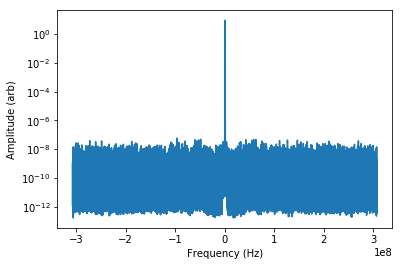

In [26]:
# plot it to see if SMuRF thinks it's outputting something
plt.semilogy(f_psd, dac_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (arb)')

Likewise, we can check what the ADC is reading. This is higher level than the timestream data that we usually take, and so it is a good check that stuff is actually reading back in.

In [27]:
adc = S.read_adc_data(2, 2**19)

[ 2019-01-31 17:33:02 ]  caput test_epics:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1


In [28]:
f_psd, adc_psd = signal.welch(adc, fs=614.4e6, nperseg=2**16, return_onesided=False)

Text(0, 0.5, 'Amplitude (arb)')

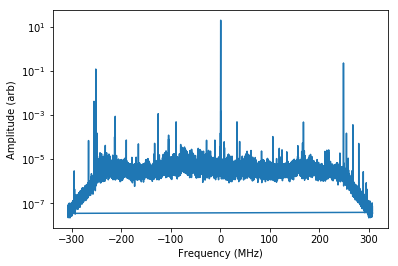

In [29]:
plt.semilogy(f_psd * 1e-6, adc_psd)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude (arb)')

This is a lot messier than the DAC data, but contains a lot of useful information! First, note that I changed the units on the x-axis, so it's now in MHz.

We can see the rolloff of the band here at about +/-250MHz. SMuRF defines everything relative to its own band/subband structure, so 0 here means we are looking at the center of the band. For the case of ADC 2, this is the center of the 5-5.5GHz band, so 5.25GHz. We could make a similar plot for band 3, which would have axes that also run from -300 to +300MHz, but the absolute frequency would be centered around 5.75GHz instead. 

We can compare this to what happens when we turn the tone off:

In [30]:
S.config_cryo_channel(2,0,0,0,0,0,0)

[ 2019-01-31 17:38:50 ]  caput test_epics:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1


Text(0, 0.5, 'Amplitude (arb)')

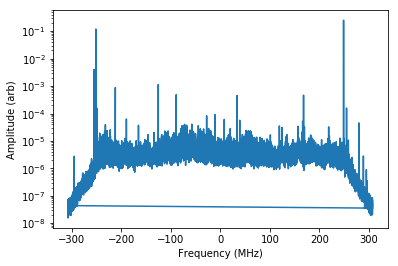

In [31]:
adc2 = S.read_adc_data(2,2**19)
f_psd, adc2_psd = signal.welch(adc2, fs=614.4e6, nperseg=2**16, return_onesided=False)
plt.semilogy(f_psd*1e-6, adc2_psd)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude (arb)')

So the obvious tone in the middle went away! This is approximately what we expect. You can try playing with the cryo channel parameters and seeing how the DAC vs ADC respond.

### Firmware Structure

Bands, subbands, channels lala

Don't think I want to get into filter stuff here?

The details of the firmware structure are likely beyond the scope of this tutorial, but there are a few small things to know about the SMuRF constraints in order to command channels appropriately.

Each _band_ of SMuRF spans 500MHz and can support up to 512 channels, which are 0-indexed. Band 0 is 4-4.5GHz and they count upwards from there. If you are ever unsure, you can check the the center of the band explicitly:

In [32]:
S.get_band_center_mhz(3)

5750.0

Each band is further subdivided into 128 _subbands_. The subbands overlap slightly; they are technically about 9.2MHz wide, but have 6MHz of useful bandwidth. These are numbered sequentially in frequency space, so subband 0 is the lowest frequency and subband 127 is the highest frequency. Since the bands technically span 600MHz (as can be seen from the plots above) with some rolloff, we only really need subbands 12-114 or so. 

The channels are assigned to the subbands in a weird, interleaved way. As discussed above, the channel frequencies are defined as offsets from the subband centers, so in practice this places a constraint on which channels can be associated with a particular frequency. 

Each subband has 4 channels; given the overlapping subbands it might be possible to use an adjacent subband channel in order to turn on more than 4 channels in a given 6MHz span but this does place a limit on the number of channels that may be tracked if fabrication variation happens to put more than 4 channels into a particular subband. Other than this constraint, we try not to talk about subbands at all.

There are some useful utilities to convert between frequency, subband, and channel, mostly in <font color=blue>pysmurf/util/</font>.

In [35]:
S.get_channels_in_subband(2,63) # for some reason this needs the band, although it shouldn't matter

[0, 32, 64, 96]

In [36]:
S.get_channel_order() # in case this was useful

[384,
 416,
 448,
 480,
 144,
 176,
 208,
 240,
 400,
 432,
 464,
 496,
 136,
 168,
 200,
 232,
 392,
 424,
 456,
 488,
 152,
 184,
 216,
 248,
 408,
 440,
 472,
 504,
 132,
 164,
 196,
 228,
 388,
 420,
 452,
 484,
 148,
 180,
 212,
 244,
 404,
 436,
 468,
 500,
 140,
 172,
 204,
 236,
 396,
 428,
 460,
 492,
 156,
 188,
 220,
 252,
 412,
 444,
 476,
 508,
 130,
 162,
 194,
 226,
 386,
 418,
 450,
 482,
 146,
 178,
 210,
 242,
 402,
 434,
 466,
 498,
 138,
 170,
 202,
 234,
 394,
 426,
 458,
 490,
 154,
 186,
 218,
 250,
 410,
 442,
 474,
 506,
 134,
 166,
 198,
 230,
 390,
 422,
 454,
 486,
 150,
 182,
 214,
 246,
 406,
 438,
 470,
 502,
 142,
 174,
 206,
 238,
 398,
 430,
 462,
 494,
 158,
 190,
 222,
 254,
 414,
 446,
 478,
 510,
 129,
 161,
 193,
 225,
 385,
 417,
 449,
 481,
 145,
 177,
 209,
 241,
 401,
 433,
 465,
 497,
 137,
 169,
 201,
 233,
 393,
 425,
 457,
 489,
 153,
 185,
 217,
 249,
 409,
 441,
 473,
 505,
 133,
 165,
 197,
 229,
 389,
 421,
 453,
 485,
 149,
 181,
 213

In [38]:
S.get_subband_from_channel(2,0) # this also cares about band, for some reason

63

In [40]:
subband_no, center = S.get_subband_centers(2)

In [41]:
subband_no[63], center[63]

(63, 0.0)

Note from above that the center is typically given as an offset from the band center. Pass the argument "as_offset=False" to get it in absolute terms:

In [42]:
subband_no, center = S.get_subband_centers(2,as_offset=False)
print(subband_no[63], center[64])

63 5254.800000190735
